In [52]:
import sys
sys.path.insert(0, "/home/szhydkov/Documents/mattei peer review/extedned_peer_selection/peerselect")

In [2]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from collections import Counter

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10)
#np.set_printoptions(threshold=np.inf)

In [4]:
# Allows to use Julia within Python
# Steps if you want to make it work:
# 1. Install Julia from https://julialang.org/downloads/
# 2. Install pyjulia:
#    $ python3 -m pip install julia
# Takes a few seconds to run the first time
import julia
julia.Julia(compiled_modules=False)
from julia import Main
Main.include("funs.jl")

<PyCall.jlwrap estimate_eps>

In [6]:
# Example usage of a function from funs.jl
# estimate_eps(n, m, k) returns the epsilon that should give the right expected size.
Main.estimate_eps(130, 10, 30)

-0.0015868684682767158

In [43]:
# Would be interesting to start with some distribution of valuations -
# EDP and such should be able to make use of more data
n = 130
k = 50
utilities = [1/(1+np.exp(0.1*(x-k))) for x in range(n)]

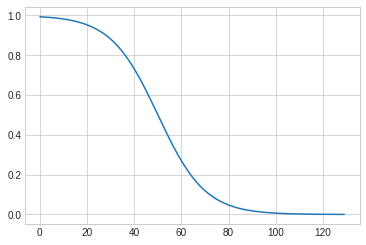

In [44]:
plt.plot(utilities)

In [124]:
_DEBUG = False

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

s = 100
test_n = [120]
test_k = [15, 20, 25, 30, 35]
test_m = [7, 8, 9, 10, 11]
test_l = [4]
test_p = [0.5]

# Map for all Results.
v_results = {}
gt_results = {}
pn_sizes = {}  #track output size of peer nomination
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Borda -- need to start at 1 to distinguish from non-review in the score matrix
        scores = np.arange(m, 0, -1)
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)

        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
#         # Set all sizes to be the same.
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        # Run peer nomination using the estimated epsilon
        ws[Impartial.NOMINATION] = impartial.peer_nomination_lottery(score_matrix, k, Main.estimate_eps(n, m, k))
        size = len(set(ws[Impartial.NOMINATION]))
#         ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, size, clustering, normalize=True)

        
        for x in Impartial.ALL:
            key = (n, k, m, l, p, s, x)
            v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            
        key = (n, k, m, l, p)
        pn_sizes[key] = pn_sizes.get(key, []) + [size]
        
    print("k = " + str(k) + ", actual average size = " + str(np.mean(pn_sizes[key])))
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
print("All done!")
    
v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df = pd.DataFrame(gt_results)
gt_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# fair_df = pd.DataFrame(gt_results)
# fair_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

# cluster2_df = pd.DataFrame(gt_results)
# cluster2_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']


k = 15, actual average size = 15.41
Finished: 120,15,7,4,0.5,100
k = 15, actual average size = 15.49
Finished: 120,15,8,4,0.5,100
k = 15, actual average size = 16.6
Finished: 120,15,9,4,0.5,100
k = 15, actual average size = 15.59
Finished: 120,15,10,4,0.5,100
k = 15, actual average size = 15.49
Finished: 120,15,11,4,0.5,100
k = 20, actual average size = 20.22
Finished: 120,20,7,4,0.5,100
k = 20, actual average size = 20.5
Finished: 120,20,8,4,0.5,100
k = 20, actual average size = 21.18
Finished: 120,20,9,4,0.5,100
k = 20, actual average size = 20.36
Finished: 120,20,10,4,0.5,100
k = 20, actual average size = 20.64
Finished: 120,20,11,4,0.5,100
k = 25, actual average size = 25.75
Finished: 120,25,7,4,0.5,100
k = 25, actual average size = 25.29
Finished: 120,25,8,4,0.5,100
k = 25, actual average size = 25.81
Finished: 120,25,9,4,0.5,100
k = 25, actual average size = 24.76
Finished: 120,25,10,4,0.5,100
k = 25, actual average size = 25.11
Finished: 120,25,11,4,0.5,100
k = 30, actual averag

In [129]:
v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

In [122]:
gt_df

n                     120                                                     \
k                      15                                                      
m                      7                                   8                   
l                       4                                   4                  
p                     0.5                                 0.5                  
s                     100                                 100                  
algo ExactDollarPartition PeerNomination ExactDollarPartition PeerNomination   
0                      13             12                   11             12   
1                      12             14                   12             13   
2                      10             11                   10             11   
3                      12             13                   12             12   
4                      12             11                   13             14   
5                      12             13                   10             11   
6                       9             11                   10             13   
7                      11             10                   11             11   
8                      11              9                   12             11   
9                      11             14                   12             11   
10                     11             11                   14             13   
11                     12             12                   13             12   
12                     13             13                   12             14   
13                     10             13                   10             12   
14                     13             13                   11             12   
15                     10             10                   10             10   
16                     11             11                   12             12   
17                     11             13                   10             11   
18                     11             13                   12             14   
19                     13             13                   11             12   
20                     14             13                   11             14   
21                     11             14                   12             12   
22                     10             11                   11             13   
23                     11             13                   12             13   
24                     11             13                   11             13   
25                     14             14                   10             10   
26                     13             13                   12             15   
27                     11             10                   12             11   
28                     10             11                   12             12   
29                     12             14                   12             13   
..                    ...            ...                  ...            ...   
70                     10             11                   10             12   
71                     11             11                   13             14   
72                     13             11                   11             11   
73                     11             12                   10             13   
74                     12             10                   11             12   
75                     13             14                   11             11   
76                     11             13                    9             10   
77                     11             11                   12             14   
78                     12             10                   11             12   
79                     13             12                   12             11   
80                     11             13                   11             11   
81                     11             12                   12             14   


([<matplotlib.axis.XTick at 0x7f3be74158d0>,
 <a list of 9 Text xticklabel objects>)

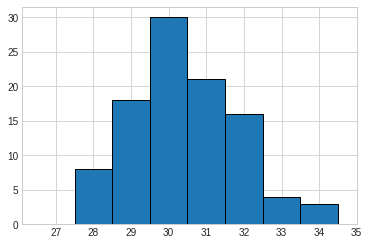

In [156]:
plt.hist(pn_sizes[(120,30,8,4,0.5)], bins=np.arange(27, 36), align="left", edgecolor="k")
plt.xticks(np.arange(27, 36))

In [92]:
len([x for x in pn_sizes[(120,25,10,5,0.0)] if x==27])


4

In [131]:
gt_df.to_pickle("db/gt_df2.pkl")
v_df.to_pickle("db/v_df2.pkl")

In [47]:
fair_df.to_pickle("db/fair_df1.pkl")

In [157]:
fair_df

n                     120                                                     \
k                      15                                                      
m                      8                                   9                   
l                       5                                   5                  
p                     0.0                                 0.0                  
s                      50                                  50                  
algo ExactDollarPartition PeerNomination ExactDollarPartition PeerNomination   
0                      12             12                   11             12   
1                      13             12                   11             13   
2                      12             15                   13             12   
3                      14             14                   11             12   
4                      10             10                   12             14   
5                       9             12                   11             12   
6                      13             15                   14             12   
7                      12             12                   13             12   
8                      11             12                   13             12   
9                      11             12                   12             13   
10                     10             12                   12             12   
11                     10             12                   12             12   
12                     13             14                   12             13   
13                      8             10                   12             12   
14                      8             10                   14             14   
15                     11             11                   13             12   
16                     13             14                   12             12   
17                     12             14                   13             12   
18                     11             13                   10             11   
19                     13             11                   12             14   
20                     10             13                   10             14   
21                     12             12                   11             12   
22                     11             13                   12             14   
23                     12             13                   12             14   
24                     10             11                   11             12   
25                     13             13                   10             10   
26                     13             12                   13             13   
27                     13             11                   11             11   
28                     14             13                   13             14   
29                      9             10                   10             11   
30                     11             13                   12             13   
31                      9             10                   13             12   
32                     12             13                   10             13   
33                     11             10                   14             13   
34                     10             13                   12             13   
35                     12             12                    9             10   
36                     12             12                   11             12   
37                     13             11                   13             13   
38                     12             13                   14             14   
39                      9             11                   10              9   
40                     10             12                   13             12   
41                     10             11                   12             12   
42                     12             14                   14             15   


		Approximate Vanilla Ordering


/home/szhydkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/szhydkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


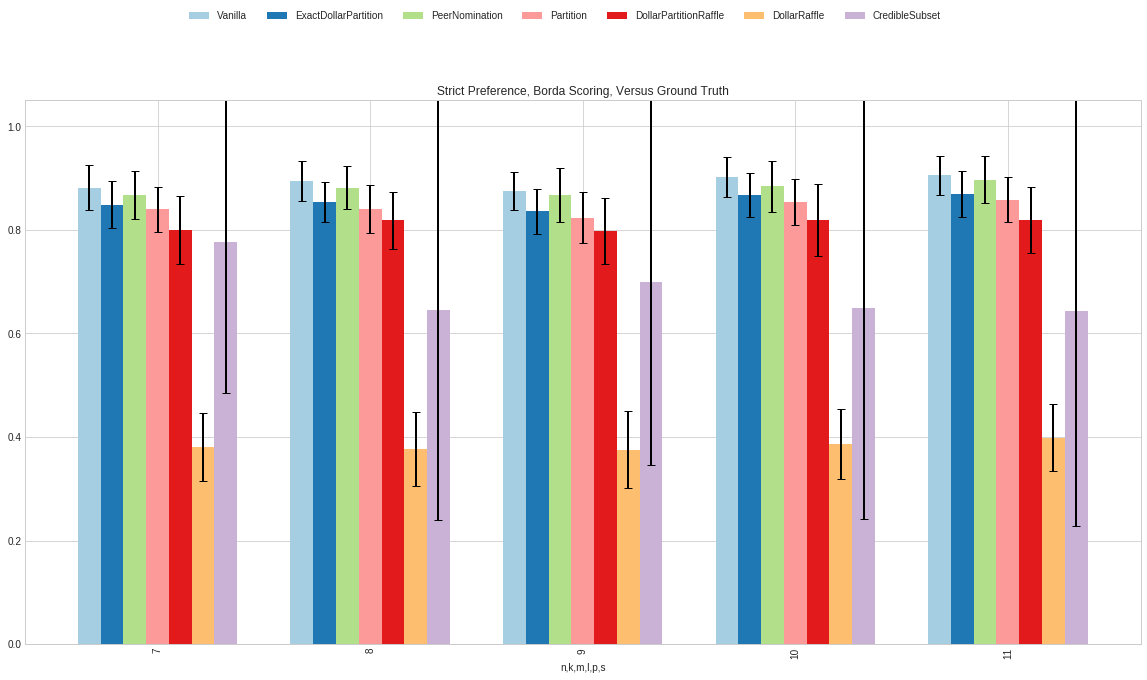

In [152]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    # print(means)
    # print(errors)

    print("\t\tApproximate Vanilla Ordering")
    means = means[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    errors = errors[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    # Uncomment to only compare PN and EDP
#     means = means[['ExactDollarPartition', "PeerNomination"]]
#     errors = errors[['ExactDollarPartition', "PeerNomination"]]
    
#     means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
#     errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
#     mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
#     print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
#     del means['PercentChange']
#     del errors['PercentChange']
#     del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.ix[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.ix[index] = row / float(index[1])
    
    # print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 10))
    color_list = color_list[:7]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(20, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75)
    plt.title("Strict Preference, Borda Scoring, Versus Ground Truth")
    plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=7, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
#     plt.gca().set_xlabel("Number of clusters")
    plt.show()
make_output(gt_df, (120,30,slice(None),4,0.5,100), test_m)

In [148]:
for k in test_k:
    print(np.mean(pn_sizes[(120,k,7,4,0.5)]))

15.41
20.22
25.75
30.67
35.35


In [140]:
pn_sizes

{(120, 15, 7, 4, 0.5): [16,
  16,
  15,
  16,
  16,
  16,
  15,
  17,
  19,
  15,
  15,
  17,
  17,
  16,
  13,
  15,
  14,
  16,
  17,
  13,
  16,
  14,
  16,
  15,
  14,
  17,
  17,
  18,
  14,
  16,
  19,
  14,
  15,
  17,
  16,
  17,
  15,
  16,
  16,
  16,
  15,
  15,
  12,
  16,
  15,
  15,
  12,
  15,
  16,
  15,
  18,
  14,
  14,
  17,
  17,
  17,
  14,
  13,
  16,
  15,
  17,
  14,
  13,
  16,
  15,
  15,
  17,
  16,
  15,
  16,
  15,
  14,
  16,
  19,
  15,
  15,
  16,
  16,
  14,
  18,
  16,
  15,
  15,
  15,
  15,
  15,
  13,
  14,
  15,
  14,
  17,
  15,
  14,
  15,
  14,
  14,
  15,
  16,
  12,
  17],
 (120, 15, 8, 4, 0.5): [18,
  17,
  16,
  16,
  14,
  14,
  17,
  15,
  14,
  15,
  16,
  15,
  14,
  18,
  14,
  14,
  15,
  17,
  18,
  15,
  17,
  17,
  16,
  15,
  15,
  16,
  15,
  18,
  17,
  15,
  17,
  12,
  13,
  14,
  13,
  17,
  18,
  15,
  14,
  18,
  14,
  15,
  18,
  15,
  12,
  15,
  16,
  16,
  14,
  13,
  15,
  16,
  15,
  15,
  14,
  17,
  17,
  16,
  17,
 